In [1]:
import torch

C:\Users\penki\cmc_pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__

'1.13.1+cu116'

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
import os
import numpy as np
import cv2
from skimage.io import imread, imsave
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

**Define model**

In [5]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models

**Define the model**

In [6]:
class ResNet18(nn.Module):

    def __init__(self, pretrained=False):
        super().__init__()

        self.backbone = models.resnet18(pretrained=pretrained)
        self.backbone.fc = nn.Identity()
        self.fc = nn.Linear(in_features=512, out_features=5)

    def forward(self, x):
        x = self.backbone(x)
        logits = self.fc(x)

        return x, logits

**Load pre-trained ckpts**

In [7]:
net = ResNet18(pretrained=False)
net.load_state_dict(torch.load("../../ckpt/resnet18_wsi224.pt"))
net.eval()

C:\Users\penki\cmc_pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\penki\cmc_pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet18(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

ResNet18(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

**Evaluate mode with pre-trained weights on the original scale**

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

batch_size = 32

testset = torchvision.datasets.ImageFolder("../../data/path-dt-msu-wsi/val", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


In [10]:
correct = 0
total = 0

with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        _, outputs = net(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network: {100 * correct // total} %')

100%|████████████████████████████████████████████████████████████████████████████████| 821/821 [00:33<00:00, 24.16it/s]

Accuracy of the network: 97 %


**Testing on real multi-scale WSI via OpenSlide library**

In [1]:
# The path can also be read from a config file, etc.
OPENSLIDE_PATH = r'C:\tools\openslide-win64-20221217\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide
    
# import large_image

from openslide import open_slide
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

In [3]:
wsi_path = r"C:\Users\penki\Documents\cmc\data\PATH-DT-MSU-WSI\WSS2\03.svs"

In [4]:
slide = open_slide(wsi_path)

In [5]:
slide.properties

<_PropertyMap {'aperio.AppMag': '40', 'aperio.Date': '11/06/20', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '45', 'aperio.Filename': '1043324', 'aperio.Focus Offset': '-0.000500', 'aperio.ICC Profile': 'AT2', 'aperio.ImageID': '1043324', 'aperio.Left': '23.844707', 'aperio.LineAreaXOffset': '0.016146', 'aperio.LineAreaYOffset': '0.001517', 'aperio.LineCameraSkew': '-0.002095', 'aperio.MPP': '0.2528', 'aperio.OriginalHeight': '65909', 'aperio.OriginalWidth': '101600', 'aperio.ScanScope ID': 'SS7315', 'aperio.SessonMode': 'NR', 'aperio.StripeWidth': '2032', 'aperio.Time': '14:51:24', 'aperio.Time Zone': 'GMT+03:00', 'aperio.Top': '19.264688', 'aperio.User': 'a8d3f0e3-63d8-4f23-a277-b4bfcf02ca71', 'openslide.comment': 'Aperio Image Library v12.0.15 \r\n101600x65909 [0,100 99600x65809] (240x240) JPEG/RGB Q=70|AppMag = 40|StripeWidth = 2032|ScanScope ID = SS7315|Filename = 1043324|Date = 11/06/20|Time = 14:51:24|Time Zone = GMT+03:00|User = a8d3

In [6]:
slide.level_dimensions

((99600, 65809), (24900, 16452), (6225, 4113), (3112, 2056))

In [16]:
def maxmin_norm(img):
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min())
    return img.astype(np.float32)

In [17]:
def get_image_scale(wsi, x_c, y_c, h, w): # add logariphmic grid
    x_0 = x_c - h//2
    y_0 = y_c - w//2

    location = (x_0, y_0)
    smaller_region = slide.read_region(location, level=0, size=(h,w))
    smaller_region = np.array(smaller_region.convert('RGB'))
    
    return maxmin_norm(smaller_region)

**Play a little bit with different scales extraction**

In [46]:
# x_c = 2000
# y_c = 5000

# x_c = 16000
# y_c = 16000

# x_c = 9000 # 0, 1, 3
# y_c = 9000

x_c = 40500 # 1
y_c = 27500

h_orig, w_orig = 224, 224

In [38]:
# l = []
# for scale in SCALE_GRID:
#     img = get_image_scale(slide, x_c, y_c, h_orig*scale, w_orig*scale)    
#     img = cv2.resize(img, (224, 224))
#     buff = np.ones(shape=(256,256,3))
#     buff[:224,:224] = img
#     l.append(buff)
# cv2.imwrite("./x_2k_y_6k.png".format(s), np.hstack(l)[:224,:]*255)

In [47]:
scale = 1

smaller_region = get_image_scale(slide, x_c, y_c, h_orig*scale, w_orig*scale)

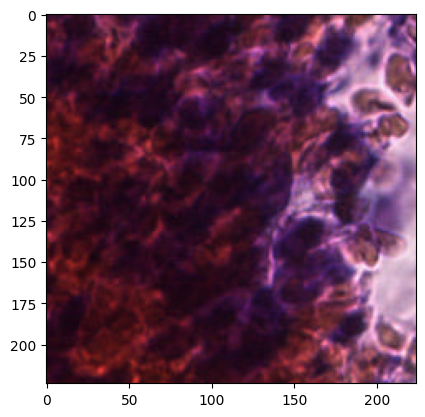

In [48]:
plt.imshow(smaller_region)

**Feed multi-scale samples to the fine-tuned NN**

In [50]:
from PIL import Image
from matplotlib import cm

In [53]:
apply_transform = transforms.Compose(
    [#transforms.Resize(256),
     #transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

**Review predictions and model's confidence in the predictions on various scales**

In [54]:
X = []
SCALE_GRID =  [1,2,4] 
for scale in SCALE_GRID:
    slide_region = get_image_scale(slide, x_c, y_c, h_orig*scale, w_orig*scale)
    img = Image.fromarray((np.clip(slide_region,0,1)*255).astype(np.uint8))
    
    img_t = apply_transform(img)[None, ...]
    img_t = img_t.to(device)
    f, logits = net(img_t)
    X.append(f.cpu().detach().numpy()[0])
    
    
    probs = F.softmax(logits, dim=-1)
    pred = torch.argmax(probs).detach().cpu().numpy().item()
    
    print("Scale: {0}; Prediciton: {1}; Probability: {2:.2f}".format(scale,
                                                                     pred,
                                                                     probs.detach().cpu().numpy()[0][pred] * 100))

Scale: 1; Prediciton: 1; Probability: 74.78
Scale: 2; Prediciton: 1; Probability: 45.96
Scale: 4; Prediciton: 1; Probability: 41.32


**Look into deep features activation...**

In [55]:
W = net.fc.weight.cpu().detach().numpy().transpose()
W.shape

(512, 5)

In [ ]:
l2_norm = np.linalg.norm(W, ord=None, axis=0)  # Frobenius norm
l2_norm.shape

In [ ]:
X = np.array(X)
X.shape

In [ ]:
dot = X.dot(W) / l2_norm[np.newaxis, ...]

In [ ]:
dot_pos = dot * (dot>0)

In [ ]:
fig, ax = plt.subplots()
for i in range(5):
    ax.plot(SCALE_GRID, dot[:,i], label=str(i))
ax.legend()
fig.savefig("out.png")

In [ ]:
fig, ax = plt.subplots()
for i in range(5):
    ax.plot(SCALE_GRID, dot_pos[:,i], label=str(i))
ax.legend()

**Visualize an entire WSI image**

In [7]:
slide_thimb_600 = slide.get_thumbnail(size=(600,600))

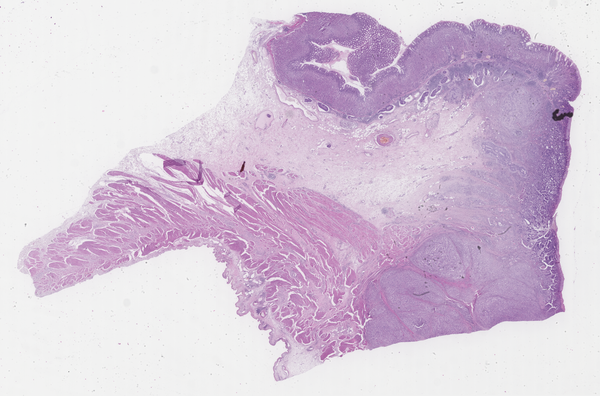

In [8]:
slide_thimb_600